# Universal Embeddings

Thesis: that all the Biblical knowledge across all languages can be encapsulated into one vector of numbers per verse;  with practical applications of

 - Quality testing new translations by comparing vector of target translation verse to universal vectors (similar projects exist or are proposed but against the single translation not the universal)
 - Seed the generation of new translations of a verse (ex. 2nd phase of transformer architecture)

## Approach #1
 - Given a verse concat text in all languages as single input -> create sentence embedding
 - In addition use each verse as a single input -> create sentence embeddings
 - store in vector db
 - foreach verse do a search and assume it will return 


### Alternate Refinements to try later
 - with and without reference (Ex. Mark 1:1)
 - With reference on each verse to overfit on the reference

## Approach #2
 - Fine tune a LLM to predict reference from all verses
 - And the opposite to generate verses correctly from just a reference
 - Thus overfitting the reference to be a super group of tokens of all verses
 - get sentence embeddings from just the reference

 


In [1]:
TRAINING_SOURCE = ['MRK']
CHAPTERS = [1]
MODEL = 'text-embedding-ada-002'

In [2]:
# Imports and fixes to pathing
%reload_ext autoreload
import sys
sys.path.append('../lib')

import pandas as pd
import tiktoken
import openai, time, os
from openai.error import RateLimitError, OpenAIError
from config import get_config
from collections import defaultdict
from cipher import substitution_cipher

openai.api_key = os.environ["OPENAI_API_KEY"] = get_config('embeddings')['api_key']


In [3]:
# Read the data/berrig.csv file into dataframe
df = pd.read_csv('../data/birrig.csv')
# rename df[0] to df['vref']
df.rename(columns={df.columns[0]: 'vref'}, inplace=True)
df.head()


,vref,book,chapter,verse,eng-web,eng-asv,eng-kjv2006,engBBE,hin2017,arbnav,latVUC,amo,source_content,birrig
0,GEN 1:1,GEN,1,1,"In the beginning, God created the heavens and ...",In the beginning God created the heavens and t...,In the beginning God created the heaven and th...,At the first God made the heaven and the earth.,आदि में परमेश्‍वर ने आकाश और पृथ्वी की सृष्टि ...,فِي الْبَدْءِ خَلَقَ اللهُ السَّمَاوَاتِ وَالأ...,In principio creavit Deus cælum et terram.,NaN,בְּרֵאשִׁ֖ית בָּרָ֣א אֱלֹהִ֑ים אֵ֥ת הַשָּׁ...,El lxi sovzl Guw newi lxi xiemir erw lxi ievlx.
1,GEN 1:2,GEN,1,2,The earth was formless and empty. Darkness was...,And the earth was waste and void; and darkness...,"And the earth was without form, and void; and ...",And the earth was waste and without form; and ...,"पृथ्वी बेडौल और सुनसान पड़ी थी, और गहरे जल के ...",وَإِذْ كَانَتِ الأَرْضُ مُشَوَّشَةً وَمُقْفِرَ...,"Terra autem erat inanis et vacua, et tenebræ e...",NaN,וְהָאָ֗רֶץ הָיְתָ֥ה תֹ֨הוּ֙ וָבֹ֔הוּ וְחֹ֖...,Erw lxi ievlx hez hezli erw holxual suvn; erw ...
2,GEN 1:3,GEN,1,3,"God said, “Let there be light,” and there was ...","And God said, Let there be light: and there wa...","And God said, Let there be light: and there wa...","And God said, Let there be light: and there wa...","तब परमेश्‍वर ने कहा, “उजियाला हो*,” तो उजियाला...",أَمَرَ اللهُ: «لِيَكُنْ نُورٌ». فَصَارَ نُورٌ،,Dixitque Deus: Fiat lux. Et facta est lux.,NaN,וַיֹּ֥אמֶר אֱלֹהִ֖ים יְהִ֣י א֑וֹר וַֽיְהִי...,"Erw Guw zeow, Pil lxivi fi pogxl: erw lxivi he..."
3,GEN 1:4,GEN,1,4,"God saw the light, and saw that it was good. G...","And God saw the light, that it was good: and G...","And God saw the light, that it was good: and G...","And God, looking on the light, saw that it was...",और परमेश्‍वर ने उजियाले को देखा कि अच्छा है*; ...,وَرَأَى اللهُ النُّورَ فَاسْتَحْسَنَهُ وَفَصَل...,Et vidit Deus lucem quod esset bona: et divisi...,NaN,וַיַּ֧רְא אֱלֹהִ֛ים אֶת־ הָא֖וֹר כִּי־ ט֑וֹ...,"Erw Guw, puucorg ur lxi pogxl, zeh lxel ol hez..."
4,GEN 1:5,GEN,1,5,"God called the light “day”, and the darkness h...","And God called the light Day, and the darkness...","And God called the light Day, and the darkness...","Naming the light, Day, and the dark, Night. An...",और परमेश्‍वर ने उजियाले को दिन और अंधियारे को ...,وَسَمَّى اللهُ النُّورَ نَهَاراً، أَمَّا الظَّ...,"Appellavitque lucem Diem, et tenebras Noctem: ...",NaN,וַיִּקְרָ֨א אֱלֹהִ֤ים׀ לָאוֹר֙ י֔וֹם וְלַחֹ...,"Renorg lxi pogxl, Wej, erw lxi wevc, Rogxl. Er..."


In [4]:
training_df = df[df['book'].isin(TRAINING_SOURCE)]
training_df = training_df[training_df['chapter'].isin(CHAPTERS)]
training_df.drop(columns=['birrig'], inplace=True)
len(training_df)

45

In [36]:
embeddings = pd.DataFrame(columns=['vref', 'version', 'input', 'embeddings'])

# Create our sentence embedding
for _, verse in training_df.iterrows():
    print(f"Processing {verse['vref']}")
    inputs = []
    # loop through all columns in verse
    for column in training_df.columns[4:]:
        # if the column has a value
        if verse[column]:
            # add the column name to the list of inputs
            inputs.append((column, f"{verse['vref']}\t{column}\t{verse[column]}"))
    combined = '\n'.join([i[1] for i in inputs])
    inputs.append(('combined', combined))

    # Create the embedding for each input
    #for (name, input) in inputs:
    #    embeddings[(name, verse['vref'])] = openai.Embedding.create(input=input, model=MODEL, engine="gpt-35-turbo-16k")['data'][0]['embedding']
    result = openai.Embedding.create(input=[input for (_, input) in inputs], model=MODEL)['data']
    for i, (version, input) in enumerate(inputs):
        embeddings.loc[len(embeddings)] = [verse['vref'], version, input, result[i]['embedding']]



Processing MRK 1:1
Processing MRK 1:2
Processing MRK 1:3
Processing MRK 1:4
Processing MRK 1:5
Processing MRK 1:6
Processing MRK 1:7
Processing MRK 1:8
Processing MRK 1:9
Processing MRK 1:10
Processing MRK 1:11
Processing MRK 1:12
Processing MRK 1:13
Processing MRK 1:14
Processing MRK 1:15
Processing MRK 1:16
Processing MRK 1:17
Processing MRK 1:18
Processing MRK 1:19
Processing MRK 1:20
Processing MRK 1:21
Processing MRK 1:22
Processing MRK 1:23
Processing MRK 1:24
Processing MRK 1:25
Processing MRK 1:26
Processing MRK 1:27
Processing MRK 1:28
Processing MRK 1:29
Processing MRK 1:30
Processing MRK 1:31
Processing MRK 1:32
Processing MRK 1:33
Processing MRK 1:34
Processing MRK 1:35
Processing MRK 1:36
Processing MRK 1:37
Processing MRK 1:38
Processing MRK 1:39
Processing MRK 1:40
Processing MRK 1:41
Processing MRK 1:42
Processing MRK 1:43
Processing MRK 1:44
Processing MRK 1:45


In [37]:
embeddings

,vref,version,input,embeddings
0,MRK 1:1,eng-web,MRK 1:1\teng-web\tThe beginning of the Good Ne...,"[0.010090361349284649, -0.012477395124733448, ..."
1,MRK 1:1,eng-asv,MRK 1:1\teng-asv\tThe beginning of the gospel ...,"[0.0038364860229194164, -0.017473477870225906,..."
2,MRK 1:1,eng-kjv2006,MRK 1:1\teng-kjv2006\tThe beginning of the gos...,"[0.005153497215360403, -0.01336921751499176, -..."
3,MRK 1:1,engBBE,MRK 1:1\tengBBE\tThe first words of the good n...,"[-0.007740882690995932, -0.023020600900053978,..."
4,MRK 1:1,hin2017,MRK 1:1\thin2017\tपरमेश्‍वर के पुत्र यीशु मसीह...,"[-0.011625968851149082, -0.007395970169454813,..."
...,...,...,...,...
445,MRK 1:45,arbnav,MRK 1:45\tarbnav\tأَمَّا هُوَ، فَانْطَلَقَ يُن...,"[-0.00922680925577879, -0.015945101156830788, ..."
446,MRK 1:45,latVUC,MRK 1:45\tlatVUC\tnan,"[-0.022063544020056725, -0.005547265522181988,..."
447,MRK 1:45,amo,MRK 1:45\tamo\tAna nuzu a tunnan bellu kogha k...,"[-0.005636000540107489, -0.013987348414957523,..."
448,MRK 1:45,source_content,MRK 1:45\tsource_content\tὁ δὲ ἐξελθὼν ἤρξα...,"[0.004581152927130461, -0.0018389824545010924,..."


## Validation Test - Find Nearest Neighbor

In [41]:
from openai.embeddings_utils import cosine_similarity
for _, verse in embeddings.iterrows():
    print(f"Processing {verse['vref']} {verse['version']} which is most similar to")
    # Remove this verse so we don't get ourselves
    #df = embeddings[(embeddings['vref'] != verse[1]['vref'] & embeddings['version'] != verse[1]['version'])]
    df = embeddings.copy()
    df['similarities'] = df.embeddings.apply(lambda x: cosine_similarity(x, verse['embeddings']))
    print(df.sort_values('similarities', ascending=False)[['input','similarities']].head(10))
    


Processing MRK 1:1 eng-web which is most similar to
                                                 input  similarities
0    MRK 1:1\teng-web\tThe beginning of the Good Ne...      1.000000
1    MRK 1:1\teng-asv\tThe beginning of the gospel ...      0.965616
3    MRK 1:1\tengBBE\tThe first words of the good n...      0.963503
2    MRK 1:1\teng-kjv2006\tThe beginning of the gos...      0.961994
9    MRK 1:1\teng-web\tThe beginning of the Good Ne...      0.945561
140  MRK 1:15\teng-web\tand saying, “The time is fu...      0.905163
130  MRK 1:14\teng-web\tNow after John was taken in...      0.901148
8    MRK 1:1\tsource_content\tἈρχὴ  τοῦ  εὐαγγελίου...      0.896903
80   MRK 1:9\teng-web\tIn those days, Jesus came fr...      0.894788
131  MRK 1:14\teng-asv\tNow after John was delivere...      0.894491
Processing MRK 1:1 eng-asv which is most similar to
                                                 input  similarities
1    MRK 1:1\teng-asv\tThe beginning of the gospel ...      1.000000

## Results

It matches well english to english but even with the combined having the greek and other in it it does not favor matching to that row.  

Example
```
Processing MRK 1:2 combined which is most similar to
                                                input  similarities
19  MRK 1:2\teng-web\tAs it is written in the prop...      1.000000
11  MRK 1:2\teng-asv\tEven as it is written in Isa...      0.952759
10  MRK 1:2\teng-web\tAs it is written in the prop...      0.952226
12  MRK 1:2\teng-kjv2006\tAs it is written in the ...      0.951048
13  MRK 1:2\tengBBE\tEven as it is said in the boo...      0.933084
29  MRK 1:3\teng-web\tthe voice of one crying in t...      0.880349
21  MRK 1:3\teng-asv\tThe voice of one crying in t...      0.878690
20  MRK 1:3\teng-web\tthe voice of one crying in t...      0.876896
18  MRK 1:2\tsource_content\tΚαθὼς  γέγραπται  ἐν ...      0.875540
22  MRK 1:3\teng-kjv2006\tThe voice of one crying ...      0.871761
```

Notice it agrees with the English versions quite closely but then it prefers Mrk 1:3 before it gets to the greek verse it should have matched.  


Likewise notice in Hindi it only matches to other Hindi

```
Processing MRK 1:3 hin2017 which is most similar to
                                                 input  similarities
24   MRK 1:3\thin2017\tजंगल में एक पुकारनेवाले का श...      1.000000
14   MRK 1:2\thin2017\tजैसे यशायाह भविष्यद्वक्ता की...      0.909254
4    MRK 1:1\thin2017\tपरमेश्‍वर के पुत्र यीशु मसीह...      0.886712
434  MRK 1:44\thin2017\tऔर उससे कहा, “देख, किसी से ...      0.885753
34   MRK 1:4\thin2017\tयूहन्ना आया, जो जंगल में बपत...      0.882649
184  MRK 1:19\thin2017\tऔर कुछ आगे बढ़कर, उसने जब्द...      0.878737
244  MRK 1:25\thin2017\tयीशु ने उसे डाँटकर कहा, “चु...      0.878726
444  MRK 1:45\thin2017\tपरन्तु वह बाहर जाकर इस बात ...      0.877296
374  MRK 1:38\thin2017\tयीशु ने उनसे कहा, “आओ; हम औ...      0.876935
234  MRK 1:24\thin2017\tउसने चिल्लाकर कहा, “हे यीशु...      0.876505
```

## Validation Test #1 - Ensure clusters correctly
Clustering takes all the similar vectors and puts them together
If all worked out well and we cluster the results into the same number of verses that we have
Then each cluster should contain only the results for that verse

In [12]:
import numpy as np
from sklearn.cluster import KMeans

matrix = np.vstack(embeddings.embeddings.values)
n_clusters = len(training_df)

kmeans = KMeans(n_clusters = n_clusters, init='k-means++', random_state=42)
kmeans.fit(matrix)
embeddings['Cluster'] = kmeans.labels_

c:\Users\chrispriebe\Documents\projects\sil-microsoft-hackathon-2023\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [13]:
embeddings

,vref,version,embeddings,Cluster
0,MRK 1:1,eng-web,"[0.010090361349284649, -0.012477395124733448, ...",13
1,MRK 1:1,eng-asv,"[0.0038420171476900578, -0.01743224821984768, ...",13
2,MRK 1:1,eng-kjv2006,"[0.005112847778946161, -0.013430949300527573, ...",13
3,MRK 1:1,engBBE,"[-0.007689869496971369, -0.02296859212219715, ...",13
4,MRK 1:1,hin2017,"[-0.011524107307195663, -0.007378040347248316,...",37
...,...,...,...,...
445,MRK 1:45,arbnav,"[-0.00922680925577879, -0.015945101156830788, ...",3
446,MRK 1:45,latVUC,"[-0.022063544020056725, -0.005547265522181988,...",11
447,MRK 1:45,amo,"[-0.005636000540107489, -0.013987348414957523,...",36
448,MRK 1:45,source_content,"[0.004581152927130461, -0.0018389824545010924,...",2


ValueError: 'color' kwarg must be a color or sequence of color specs.  For a sequence of values to be color-mapped, use the 'c' argument instead.

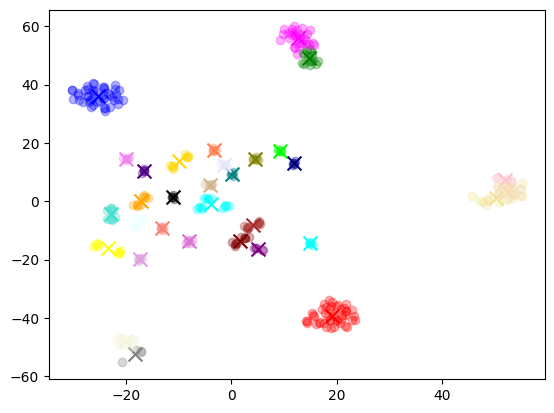

In [16]:
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

for category, color in enumerate(["purple", "green", "red", "blue", "orange", "yellow", "pink", "brown", "black", "gray", "cyan", "magenta", "lime", "olive", "maroon", "navy", "teal", "aqua", "gold", "indigo", "violet", "turquoise", "tan", "orchid", "salmon", "plum", "khaki", "coral", "wheat", "azure", "beige", "lavender", "mint", "ivory", "chartreuse", "snow", "crimson", "slate", "tomato", "fuchsia", "hotpink", "darkgreen", "darkblue", "darkred", "darkorange", "darkcyan", "darkmagenta", "darkkhaki", "darkolivegreen", "darkorchid", "darkgoldenrod", "darkslategray", "darkturquoise", "darkviolet", "deeppink", "deepskyblue", "dimgray", "dodgerblue", "firebrick", "forestgreen", "gainsboro", "ghostwhite", "goldenrod", "greenyellow", "honeydew", "hotpink", "indianred", "khaki", "lavenderblush", "lawngreen", "lemonchiffon", "lightblue", "lightcoral", "lightcyan", "lightgoldenrodyellow", "lightgray", "lightgreen", "lightpink", "lightsalmon", "lightseagreen", "lightskyblue", "lightslategray", "lightsteelblue", "lightyellow", "limegreen", "linen", "mediumaquamarine", "mediumblue", "mediumorchid", "mediumpurple", "mediumseagreen", "mediumslateblue", "mediumspringgreen", "mediumturquoise", "mediumvioletred", "midnightblue", "mistyrose", "moccasin", "navajowhite", "oldlace", "olivedrab", "orangered", "orchid", "palegoldenrod", "palegreen", "paleturquoise", "palevioletred", "papayawhip", "peachpuff", "peru", "powderblue", "rosybrown", "royalblue", "saddlebrown", "sandybrown", "seagreen", "seashell", "sienna", "silver"]):
    xs = np.array(x)[embeddings.Cluster == category]
    ys = np.array(y)[embeddings.Cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)
plt.title("Clusters identified visualized in language 2d using t-SNE")

### Notes
Well not sure what that all means, it might be that the verses are just similar to each other but it is not what I was expecting which was the same number of clusters as verses


In [26]:
def analyze(cluster):
    cluster_id = cluster.Cluster.unique()[0]
    print(f"Cluster {cluster_id} has {len(cluster)} verses")
    #print(cluster.version.value_counts())
    #print(cluster.vref.unique())

# Join the rows by clusters and identify which verses are used in each cluster
embeddings.groupby('Cluster').apply(lambda x: analyze(x))

Cluster 0 has 5 verses
Cluster 1 has 15 verses
Cluster 2 has 45 verses
Cluster 3 has 45 verses
Cluster 4 has 10 verses
Cluster 5 has 10 verses
Cluster 6 has 6 verses
Cluster 7 has 10 verses
Cluster 8 has 5 verses
Cluster 9 has 4 verses
Cluster 10 has 15 verses
Cluster 11 has 30 verses
Cluster 12 has 5 verses
Cluster 13 has 5 verses
Cluster 14 has 10 verses
Cluster 15 has 5 verses
Cluster 16 has 5 verses
Cluster 17 has 5 verses
Cluster 18 has 10 verses
Cluster 19 has 5 verses
Cluster 20 has 5 verses
Cluster 21 has 10 verses
Cluster 22 has 5 verses
Cluster 23 has 5 verses
Cluster 24 has 5 verses
Cluster 25 has 5 verses
Cluster 26 has 9 verses
Cluster 27 has 5 verses
Cluster 28 has 19 verses
Cluster 29 has 10 verses
Cluster 30 has 9 verses
Cluster 31 has 5 verses
Cluster 32 has 5 verses
Cluster 33 has 10 verses
Cluster 34 has 10 verses
Cluster 35 has 5 verses
Cluster 36 has 32 verses
Cluster 37 has 11 verses
Cluster 38 has 5 verses
Cluster 39 has 5 verses
Cluster 40 has 5 verses
Cluster 4

""
